In [180]:
from power_outage_data import load_yearly_data, load_fips_shapes, lat_lon_to_fips
from storm_data import (
    load_clusters,
    load_tracks,
    date_str_to_storm_time,
    storm_time_to_datetime,
    get_intensity
)

yearly_power_data = load_yearly_data()
fips_shapes = load_fips_shapes()
clusters = load_clusters()
# Load tracks and prefilter for year.
tks = load_tracks()
tks = tks.where(tks.season>=2014, drop=True)

In [ ]:
# iterate over each cluster

def lookup_storms_in_cluster(cluster):
    storm_dicts = []
    for _, row in cluster.iterrows():
        d = row.to_dict()
        start = date_str_to_storm_time(d['first_landfall_time']) - 0.01
        end = date_str_to_storm_time(d['final_landfall_time']) + 0.01
        sid = bytes(d['sid'], 'utf-8')

        storms = tks.where(
            (tks['time'] >= start) & (tks['time'] <= end) & (tks['sid'] == sid),
            drop=True
        )
        storm = storms.sel(storm=0)
        lon = storm.lon.values
        lat = storm.lat.values
        if (lon.size == 0) or (lat.size == 0):
            print(f"Couldn't find data for storm {d['name']} with sid {sid}")
            continue
        fips_codes = []
        county = []
        state = []
        for lat, lon in zip(lat, lon):
            fips = lat_lon_to_fips(lat, lon, fips_shapes)
            if fips:
                fips_codes.append(fips['id'])
                county.append(fips['properties']['NAME'])
                state.append(fips['properties']['STATE'])
            else:
                fips_codes.append(None)
                county.append(None)
                state.append(None)

        storm_dict = {
            **d,
            'year': int(storm.season.values[0]),
            'intensity': get_intensity(storm),
            'times': [storm_time_to_datetime(time) for time in storm.time.values],
            'lon': storm.lon.values,
            'lat': storm.lat.values,
            'fips_code': fips_codes,
            'county': county
        }
        storm_dicts.append(storm_dict)

    return storm_dicts


cluster_0 = list(clusters)[0][1]
cluster_0_storms = lookup_storms_in_cluster(cluster_0)
cluster_0_storms[1]


{'storm': 21,
 'sid': '2019299N25265',
 'name': 'OLGA',
 'fullmoment_label': 0,
 'spatmoment_label': 0,
 'first_landfall_time': '2019-10-26 06:00:00',
 'final_landfall_time': '2019-10-27 15:00:00',
 'year': 2019,
 'intensity': np.float32(45.0),
 'times': [datetime.datetime(2019, 10, 26, 6, 0),
  datetime.datetime(2019, 10, 26, 9, 0),
  datetime.datetime(2019, 10, 26, 12, 0),
  datetime.datetime(2019, 10, 26, 15, 0),
  datetime.datetime(2019, 10, 26, 18, 0),
  datetime.datetime(2019, 10, 26, 21, 0),
  datetime.datetime(2019, 10, 27, 0, 0),
  datetime.datetime(2019, 10, 27, 3, 0),
  datetime.datetime(2019, 10, 27, 6, 0),
  datetime.datetime(2019, 10, 27, 9, 0),
  datetime.datetime(2019, 10, 27, 12, 0),
  datetime.datetime(2019, 10, 27, 15, 0)],
 'lon': array([-91.200005, -90.554405, -90.      , -89.65197 , -89.3     ,
        -88.67649 , -88.      , -87.565056, -87.      , -86.10014 ,
        -84.7     , -82.69062 ], dtype=float32),
 'lat': array([28.8     , 30.048195, 31.7     , 33.8744

# Visualize a cluster

Could not join power data for storm IDALIA
Error processing storm IDALIA: ['percent_change']


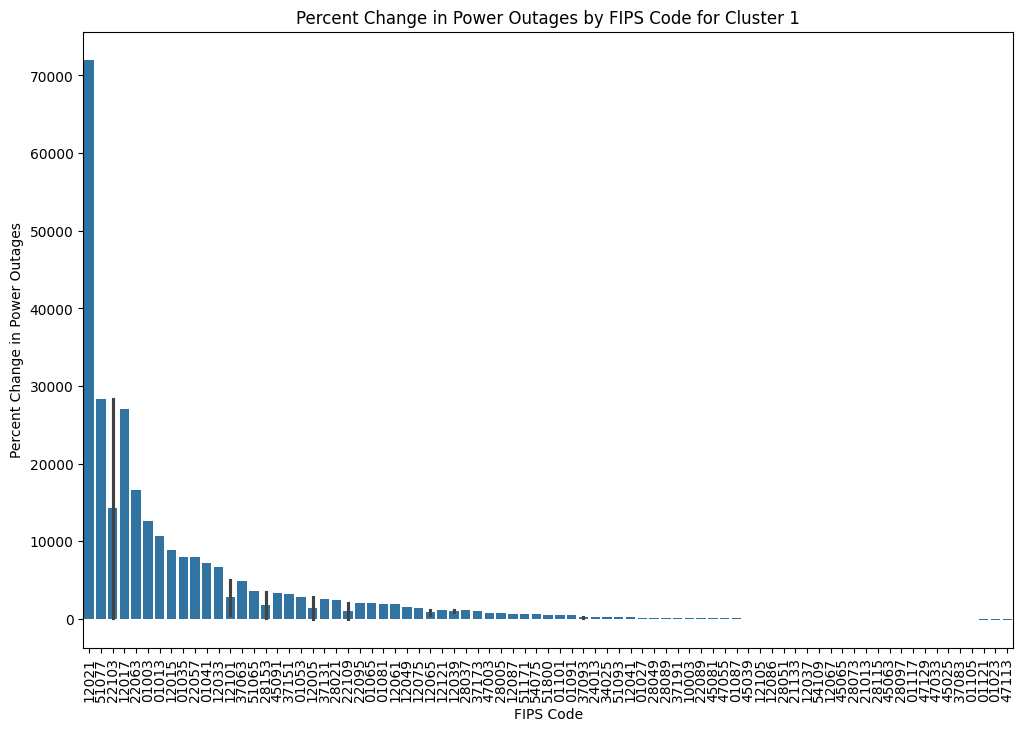

In [196]:
import pandas as pd

def get_blackouts_by_fip_for_storm(storm):
    power_outage_data = yearly_power_data[storm['year']]

    storm_df = pd.DataFrame({
        'fips_code': storm['fips_code'],
        'date': [time.date() for time in storm['times']],
        'hour': [time.hour for time in storm['times']],
        'lat': storm['lat'],
        'lon': storm['lon'],
    })
    merged  = storm_df.merge(power_outage_data.drop(columns='hour'), on=['fips_code', 'date'], how='left')
    if 'customers_out' not in merged.columns:
        print(f"Could not join power data for storm {storm['name']}")
        return pd.DataFrame()
    # Fill NaNs in the customers_out column with 0
    merged['customers_out'] = merged['customers_out'].fillna(0)

    affected_fips = [code for code in merged['fips_code'].unique() if code]
    data = []
    for fips_code in affected_fips:
        # Retrieve customers_out data from the week before the storm
        before_storm = power_outage_data[
            (power_outage_data['fips_code'] == fips_code) &
            (power_outage_data['date'] >= storm['times'][0].date() - pd.Timedelta(days=14)) &
            (power_outage_data['date'] < storm['times'][0].date() - pd.Timedelta(days=7))
        ]
        during_storm = power_outage_data[
            (power_outage_data['fips_code'] == fips_code) &
            (power_outage_data['date'] >= storm['times'][0].date()) &
            (power_outage_data['date'] < storm['times'][-1].date() + pd.Timedelta(days=7))
        ]
        after_storm = power_outage_data[
            (power_outage_data['fips_code'] == fips_code) &
            (power_outage_data['date'] >= storm['times'][-1].date() + pd.Timedelta(days=7)) &
            (power_outage_data['date'] < storm['times'][-1].date() + pd.Timedelta(days=14))
        ]

        before = before_storm['customers_out'].max()
        during = during_storm['customers_out'].max()
        after = after_storm['customers_out'].max()
        percent_change = (during - before) / before * 100
        data.append({
            'fips_code': fips_code,
            'before': before,
            'during': during,
            'after': after,
            'percent_change': percent_change
        })

    return pd.DataFrame(data)

def get_blackouts_by_fip_for_cluster(cluster):
    cluster_storms = lookup_storms_in_cluster(cluster)
    data = []
    for storm in cluster_storms:
        try:
            blackout_data = get_blackouts_by_fip_for_storm(storm)
            blackout_data.dropna(subset=['percent_change'], inplace=True)
            data.append(blackout_data)
        except Exception as e:
            print(f"Error processing storm {storm['name']}: {e}")
    return pd.concat(data)


# Plot the fips percent change for each fips code in the cluster
import matplotlib.pyplot as plt
import seaborn as sns

def plot_blackouts_for_cluster(cluster_id, cluster):
    blackouts = get_blackouts_by_fip_for_cluster(cluster)
    fig, ax = plt.subplots(figsize=(12, 8))
    blackouts.sort_values(by='percent_change', ascending=False, inplace=True)
    sns.barplot(data=blackouts, x='fips_code', y='percent_change', ax=ax)
    ax.set_title(f'Percent Change in Power Outages by FIPS Code for Cluster {cluster_id}')
    ax.set_ylabel('Percent Change in Power Outages')
    ax.set_xlabel('FIPS Code')
    plt.xticks(rotation=90)
    plt.show()

# plot_blackouts_for_cluster(*list(clusters)[0])
plot_blackouts_for_cluster(*list(clusters)[1])